In [ ]:
from leap import LeapForCausalLM, LeapConfig
from transformers import TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset

from itertools import chain

In [ ]:
# t5 tokenzier, warning is nothing to worry about since we will group the texts
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")

C:\Users\micha\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
raw_datasets = load_dataset("wikitext", "wikitext-2-v1")
column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]
block_size = 2048

def tokenize_function(examples):
    output = tokenizer(examples[text_column_name])
    return output

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_datasets = raw_datasets.map(
            tokenize_function,
            batched=True,
            num_proc=1,
            remove_columns=column_names,
        )

lm_dataset = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=1,
    desc=f"Grouping texts in chunks of {block_size}",
)

lm_dataset.set_format('pt')

Reusing dataset wikitext (C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f37a0e1d2b8653e1.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-11f852fec431ca73.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f34b03b1d56e9cb0.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-75498eacd22f25cc.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-0d438b212cccd

In [ ]:
# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "epoch",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    report_to = "none",
    learning_rate = 5e-4, 
    num_train_epochs = 25,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    max_grad_norm = 1,
    fp16 = True
)
# learning rates tried 1e-4, 5e-4, 1e-3
# 5e-4 yielded best results on BOTH windowed additive attention and gpt in terms of validation loss

# 1. LEAP Transformer (with windowing)

In [ ]:
config = LeapConfig(
    hidden_size = 128,
    vocab_size = len(tokenizer),
    n_positions = block_size,
    n_heads = 4,
    n_layer = 6,
    use_local_att = True,
    window_sizes = None, # will be set automatically
    hidden_dropout_prob = .1,
    rescale = 15 # set a little higher than normal just to try
)
window_model = LeapForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in window_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'5.6M'

In [ ]:
window_trainer = Trainer(
    model=window_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

window_trainer.train()

In [ ]:
import torch
window_model.cpu()
torch.cuda.empty_cache()

# 2. GPT2 (comparision)

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel
config = GPT2Config(n_embd = 128, vocab_size=len(tokenizer),
                    n_positions = block_size, n_layer = 6, n_head = 4,
                    resid_pdrop = .1, embd_pdrop = .1, attn_pdrop = .1,
                    use_cache = False 
                   )
gpt_model = GPT2LMHeadModel(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in gpt_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'5.6M'

In [ ]:
gpt_trainer = Trainer(
    model=gpt_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

gpt_trainer.train()

# Results

In [ ]:
def format_num_param(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f'{(total_params / 1e6):2.1f}M'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

loss1 = pd.DataFrame(window_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss2 = pd.DataFrame(gpt_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
results = pd.DataFrame({f"LEAP Transformer ({format_num_param(window_model)} parameters)": loss1,
                        f"GPT2 ({format_num_param(gpt_model)} parameters)": loss2
                       })
results.to_csv("preliminary_results.csv")
results

,LEAP Transformer (5.6M parameters),GPT2 (5.6M parameters)
epoch,,
1.0,5.412261,5.130702
2.0,4.976839,4.886001
3.0,4.733137,4.756009
4.0,4.541741,4.664287
5.0,4.417483,4.586405
6.0,4.306877,4.514636
7.0,4.224956,4.464148
8.0,4.171526,4.419113
9.0,4.117126,4.382271


In [ ]:
ppl_results = np.exp(results)
ppl_results

,LEAP Transformer (5.6M parameters),GPT2 (5.6M parameters)
epoch,,
1.0,224.137793,169.135732
2.0,145.015204,132.422969
3.0,113.651489,116.280933
4.0,93.854093,106.089926
5.0,82.887383,98.141006
6.0,74.208384,91.344314
7.0,68.371465,86.846967
8.0,64.814311,83.022585
9.0,61.382604,80.019537


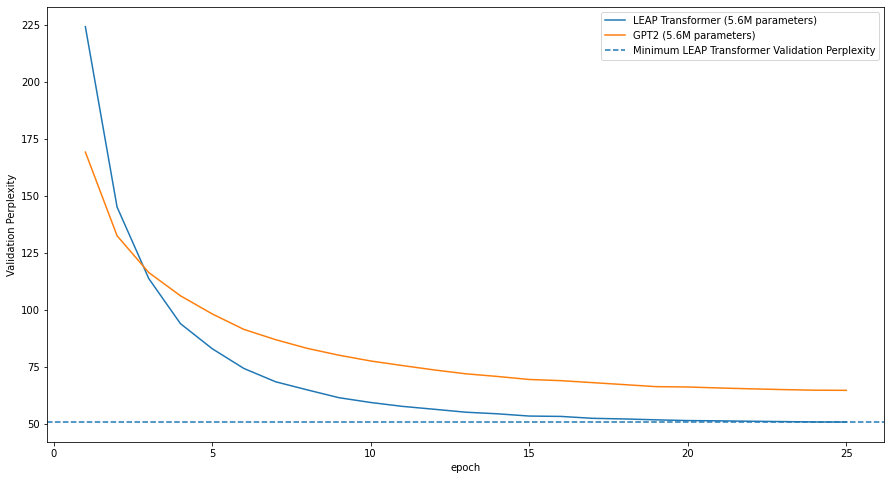

In [ ]:
ppl_results.plot()

plt.ylabel("Validation Perplexity")
plt.axhline(y=ppl_results[f"LEAP Transformer ({format_num_param(window_model)} parameters)"].min(),
            linestyle='--', label = "Minimum LEAP Transformer Validation Perplexity", color = 'C0')
plt.legend()
plt.savefig('preliminary_results.png', dpi = 100)
plt.show()

# Appendix

## Test set evaluation (DO NOT TUNE ON THIS, SHOULD ONLY BE RUN FOR BENCHMARKING PURPOSES)

In [ ]:
window_model.cuda()
result = window_trainer.evaluate(lm_dataset["test"])
torch.e**result["eval_loss"]

***** Running Evaluation *****
  Num examples = 151
  Batch size = 2


47.51456523954427

In [ ]:
gpt_model.cuda()
result = gpt_trainer.evaluate(lm_dataset["test"])
torch.e**result["eval_loss"]

***** Running Evaluation *****
  Num examples = 151
  Batch size = 2


59.66087543042275

## Test code to try some text generation

In [ ]:
# test_number = 94

# input_ids = lm_dataset["test"][test_number]["input_ids"].reshape(1, -1).cpu()
# attention_mask = lm_dataset["test"][test_number]["attention_mask"].reshape(1, -1).cpu()
# labels = lm_dataset["test"][test_number]["labels"].reshape(1, -1).cpu()

In [ ]:
# test_model = window_model

# test_model = test_model.cpu().eval()
# out = test_model(input_ids=input_ids, labels = labels, attention_mask = attention_mask)
# logits = out.logits
# loss = out.loss
# loss

In [ ]:
# tokenizer.batch_decode(input_ids[:,:50])

In [ ]:
# generated_tokens = test_model.generate(input_ids[:,:50], attention_mask = attention_mask, do_sample=True, max_length=256, temperature = .7)
# tokenizer.batch_decode(generated_tokens)

## Reuse GPT2 results from fastformerLM testing

In [ ]:
# results = pd.read_csv("src/leap/fastformerLM/preliminary_results.csv")
# results = pd.DataFrame(results.set_index("epoch")["GPT2 (5.6M parameters)"])
# results = results.join(loss1.rename(f"LEAP Transformer ({format_num_param(window_model)} parameters)"))
# results = results[[results.columns[1], results.columns[0]]]
# results

# Playing with GPT2 to see if loss spikes can be reproduced

In [ ]:
# from transformers import GPT2Config, GPT2LMHeadModel
# config = GPT2Config(n_embd = 128, vocab_size = len(tokenizer),
#                     n_positions = block_size, n_layer = 1, n_head = 1,
#                     resid_pdrop = .1, embd_pdrop = .1, attn_pdrop = .1,
#                     use_cache = False 
#                    )
# gpt_model = GPT2LMHeadModel(config)

In [ ]:
# help(gpt_model.transformer.h[0].attn._attn)